# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, breaks_cusumolsresid
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import yeojohnson, yeojohnson_normmax, jarque_bera
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from joblib import Parallel, delayed

warnings.filterwarnings('ignore')

# Data Loading & Visualisation

In [2]:
# Load the data
qqq = pd.read_excel('../data/qqq_data.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Check the data
display(qqq.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,QQQ,34.320947,34.492167,31.213309,32.018024,2234773200,-0.063126,-0.062605,0.010865,-0.000522,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-02-01,QQQ,32.095091,32.942606,31.418755,31.863935,1765610600,-0.004813,-0.005666,0.010056,0.000853,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-03-01,QQQ,31.992344,32.779963,30.768126,31.307474,2133973700,-0.017464,-0.018855,0.008751,0.001391,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-04-01,QQQ,31.521498,31.735519,29.406934,29.946276,2345433600,-0.043478,-0.041645,0.012613,-0.001833,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True
2005-05-01,QQQ,30.049009,32.762837,29.869230,32.600197,1881340000,0.088623,0.085755,0.006330,0.002868,...,58.0,1.18,20,Invesco,Large Growth,1999-03-10,0.005014,101,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [3]:
# Get information about the data
print("QQQ Data Info:")
display(qqq.describe())
print("\nMacro Data Info:")
display(macro.describe())

QQQ Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Absolute_Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,2.400000e+02,240.00000,240.0,240.00,240.0,240,240.000000,240.0
mean,141.854185,148.410727,135.854721,143.609570,1.380399e+09,0.012765,0.012160,0.012097,0.000605,0.001171,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
min,23.522952,26.702119,21.696006,23.878576,3.074376e+08,-0.155763,-0.162953,0.002915,-0.007349,0.000002,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
25%,41.132771,43.758852,39.327759,41.804646,6.974952e+08,-0.018018,-0.018936,0.007918,-0.000234,0.000434,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
50%,94.027525,97.665560,90.360646,95.052735,1.008536e+09,0.017680,0.017121,0.010193,0.000628,0.000892,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
75%,192.992068,208.999052,183.989309,198.462799,1.776189e+09,0.048497,0.047817,0.014446,0.001344,0.001540,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
max,509.427621,537.480547,507.712944,514.842224,7.240780e+09,0.149738,0.151918,0.057591,0.008237,0.008237,3.335534e+11,5.308200e+02,30.85654,58.0,1.18,20.0,1999-03-10 00:00:00,0.005014,101.0
std,126.109204,132.364382,120.760418,127.951458,9.793356e+08,0.052866,0.052700,0.006933,0.001482,0.001090,0.000000e+00,1.139244e-13,0.00000,0.0,0.00,0.0,NaN,0.000000,0.0



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


In [4]:
# y=0 dashed line
def add_zero_line(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

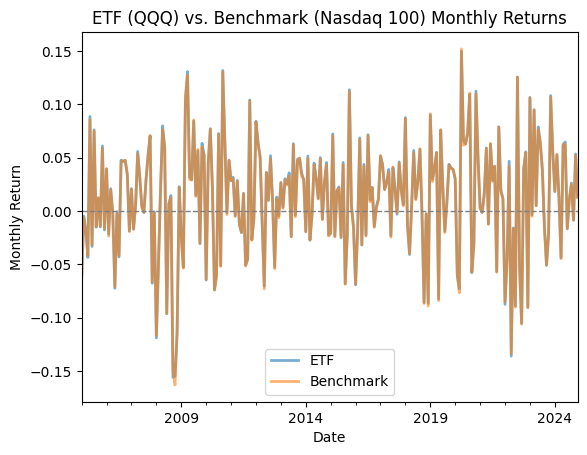

In [5]:
# ETF Returns vs Benchmark Returns
plt.figure()
ax = qqq['ETF_Return'].plot(alpha=0.6, linewidth=2, label='ETF')
qqq['Benchmark_Return'].plot(alpha=0.6, linewidth=2, label='Benchmark', ax=ax)
add_zero_line(ax)
plt.title('ETF (QQQ) vs. Benchmark (Nasdaq 100) Monthly Returns')
plt.xlabel('Date'); plt.ylabel('Monthly Return')
plt.legend()
plt.show()

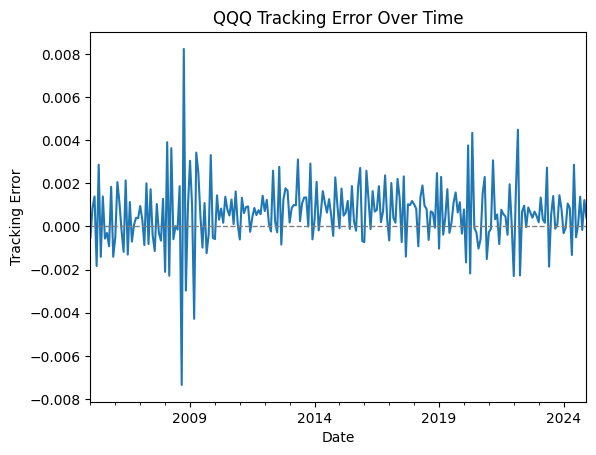

In [6]:
# Tracking Error Plot
plt.figure()
ax = qqq['Tracking_Error'].plot()
add_zero_line(ax)
plt.title('QQQ Tracking Error Over Time')
plt.xlabel('Date'); plt.ylabel('Tracking Error')
plt.show()

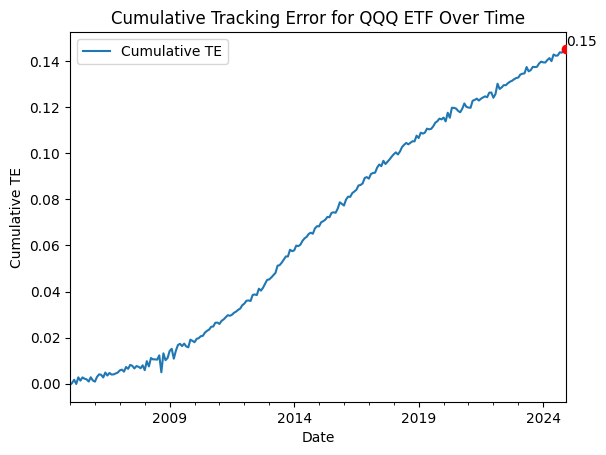

In [7]:
# Cumulative Tracking Error with final‐value marker
cum_te = qqq['Tracking_Error'].cumsum()
plt.figure()
ax = cum_te.plot(label='Cumulative TE')
# Mark & annotate final point
last_date = cum_te.index[-1]
last_val  = cum_te.iloc[-1]
ax.scatter([last_date], [last_val], color='red', zorder=5)
ax.text(last_date, last_val,
        f"{last_val:.2f}",
        va='bottom', ha='left')

plt.title('Cumulative Tracking Error for QQQ ETF Over Time')
plt.xlabel('Date'); plt.ylabel('Cumulative TE')
plt.legend()
plt.show()

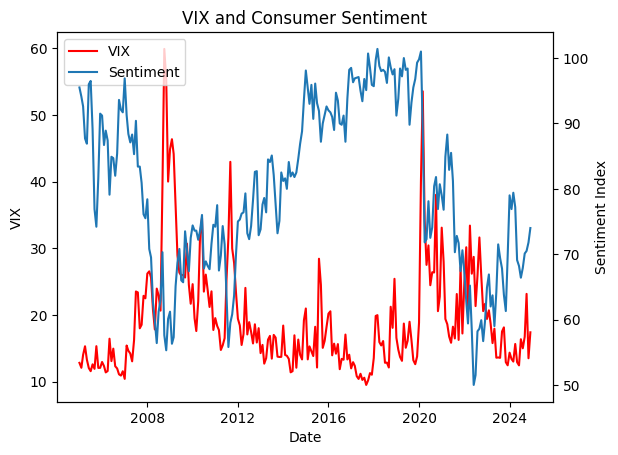

In [8]:
# VIX & Sentiment plots
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

ax2 = ax1.twinx()
ax2.plot(macro['michigan_consumer_sentiment_index'], label='Sentiment')
ax2.set_ylabel('Sentiment Index')

# combine legends
lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labs1+labs2, loc='upper left')
plt.title('VIX and Consumer Sentiment')
plt.show()

# SARIMA-GARCH Model Fitting

### Transforms & Inverses Functions

In [9]:
def winsorize_yj(
    series: pd.Series,
    limits: tuple = (0.01, 0.01)
):
    """Winsorise, shift-positive, Yeo-Johnson-transform."""
    w = winsorize(series.values, limits=limits)
    s_w = pd.Series(w, index=series.index)
    shift = -s_w.min() + 1e-6          # ensure strictly positive
    shifted = s_w + shift
    lam = yeojohnson_normmax(shifted)
    transformed = yeojohnson(shifted, lmbda=lam)
    return transformed, {"lambda": lam, "shift": shift}


def inv_yj(arr: np.ndarray, params: dict) -> np.ndarray:
    """Inverse Yeo-Johnson given dict{'lambda','shift'}."""
    lam, sh = params["lambda"], params["shift"]
    x = np.asarray(arr, float)
    pos, neg = x >= 0, x < 0
    y = np.zeros_like(x)
    # positive branch
    y[pos] = (np.power(x[pos] * lam + 1, 1 / lam) - 1) if lam != 0 else (np.exp(x[pos]) - 1)
    # negative branch
    y[neg] = 1 - np.power(-x[neg] * (2 - lam) + 1, 1 / (2 - lam)) if lam != 2 else 1 - np.exp(-x[neg])
    return y - sh


### Diagnostic Helper Functions

In [10]:
def run_diagnostics(
    resid: pd.Series,
    lags: int = 10,
    alpha: float = 0.05,
    with_cusum: bool = True
):
    lb = acorr_ljungbox(resid, lags=[lags], return_df=True).iloc[0]
    jb_s, jb_p = jarque_bera(resid)[:2]
    arch_s, arch_p, *_ = het_arch(resid, nlags=lags)

    diag = {
        "Ljung-Box":   (lb["lb_stat"], lb["lb_pvalue"]),
        "Jarque-Bera": (jb_s, jb_p),
        "ARCH LM":     (arch_s, arch_p),
    }

    if with_cusum:
        cb = breaks_cusumolsresid(resid, ddof=0)

        if len(cb) == 3:                        # new statsmodels (stat, pval, crit)
            c_stat, p_val, crit_vals = cb
        else:                                   # old statsmodels (stat, pval)
            c_stat, p_val = cb
            crit_vals = np.nan

        diag["CUSUM"] = (c_stat, p_val)

    # add pass/fail
    diag = {
        k: {"stat": v[0], "pvalue": v[1], "Result": "Pass" if v[1] > alpha else "Fail"}
        for k, v in diag.items()
    }
    return diag

### SARIMA Fitting Function

In [11]:
def fit_sarima(
    series: pd.Series,
    seasonal_period: int = 12,
    winsor_limits: tuple = (0.01, 0.01),
    ic: str = "bic",
    max_order: int = 3,          # <= speed boost
    n_jobs: int = 1,             # avoid nested parallel
):
    ts_t, tf_par = winsorize_yj(series, limits=winsor_limits)

    model = auto_arima(
        ts_t,
        seasonal=True, m=seasonal_period,
        information_criterion=ic,
        max_p=max_order, max_q=max_order, max_d=max_order,
        max_P=max_order, max_Q=max_order, max_D=max_order,
        stepwise=True,             # fast stepwise search
        suppress_warnings=True, error_action="ignore",
        n_jobs=n_jobs,
    )

    fitted = inv_yj(model.predict_in_sample(), tf_par)
    resid_vals = model.arima_res_.resid
    resid_idx  = series.index[-len(resid_vals):]
    resids     = pd.Series(resid_vals, index=resid_idx)

    # coefficient table with p-values
    sar_params = pd.DataFrame({
        "coef":   model.arima_res_.params,
        "pvalue": model.arima_res_.pvalues
    })

    return {
        "model":  model,
        "order":  model.order + model.seasonal_order,
        "aic":    float(model.arima_res_.aic),
        "bic":    float(model.arima_res_.bic),
        "fitted": pd.Series(fitted, index=series.index[-len(fitted):]),
        "resid":  resids,
        "tf_par": tf_par,
        "coef":   sar_params,
    }

### Rolling Cross-Validation Function

In [12]:
def rolling_cv(
    series: pd.Series,
    horizon: int,
    window: int,
    step: int,
    fit_fun,
    fit_kwargs: dict | None = None,
    plot_folds: bool = False,
):
    """Generic rolling-window CV. fit_fun must accept (train_series, **fit_kwargs)
    and return a dict with key 'forecast' giving np.ndarray of length=horizon."""
    fit_kwargs = fit_kwargs or {}
    n = len(series)
    fold_ends = range(window, n - horizon + 1, step)

    def _one_fold(end_idx: int):
        train = series.iloc[end_idx - window : end_idx]
        test  = series.iloc[end_idx : end_idx + horizon]
        res   = fit_fun(train, **fit_kwargs)
        fc    = res["forecast"]
        return (
            mean_absolute_error(test, fc),
            mean_squared_error(test, fc),
            r2_score(test, fc),
            fc,  # keep for optional plotting
            test,
        )

    outs = Parallel(n_jobs=fit_kwargs.get("n_jobs", -1))(delayed(_one_fold)(e) for e in fold_ends)
    mae, mse, r2, fc_all, y_all = zip(*outs)
    stats = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    if plot_folds:
        plt.figure(figsize=(8,4))
        plt.errorbar(range(len(mae)), mae, yerr=np.std(mae), fmt='o')
        plt.title("MAE per fold"); plt.show()

    return stats


### SARIMA-GARCH Model

In [13]:
def fit_sarima_garch(
    series: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,       # minimum initial window
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    ljungbox_lags: int = 10,
    alpha: float = 0.05,
    n_jobs: int = -1,          # joblib parallel folds
    arima_jobs: int = 1,       # workers inside auto_arima
    max_pq: int = 5, max_dD: int = 3,
    forecast_plot: bool = True,
) -> dict:
    """
    Expanding-window CV SARIMA + GARCH(1,1).

    Returns the same keys as before:
      order, aic, bic, sarima_coef, garch_coef, diagnostics,
      cv_metrics (lists + mean/std), metrics (in/out).
    """

    # ── checks & setup ───────────────────────────────────────────────────────
    y = series.dropna()
    if len(y) < cv_window + horizon:
        raise ValueError("series too short for chosen cv_window + horizon")

    fold_ends = range(cv_window, len(y) - horizon + 1, cv_step)

    # ── 1. expanding-window CV (auto_arima each fold) ───────────────────────
    def _cv_fold(end):
        train = y.iloc[:end]                 # expanding window
        test  = y.iloc[end:end + horizon]

        tr_t, tf_par = winsorize_yj(train, winsor_limits)

        model = auto_arima(
            tr_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )

        fc = inv_yj(model.predict(horizon), tf_par)
        return (
            mean_absolute_error(test, fc),
            mean_squared_error(test, fc),
            r2_score(test, fc),
        )

    mae, mse, r2 = map(
        list,
        zip(*Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends))
    )

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ── 2. final model on full training (all-but-horizon) ───────────────────
    train, test = y.iloc[:-horizon], y.iloc[-horizon:]
    tr_t, tf_par = winsorize_yj(train, winsor_limits)

    model = auto_arima(
        tr_t,
        seasonal=True, m=seasonal_period,
        information_criterion="bic",
        max_p=max_pq, max_q=max_pq, max_d=max_dD,
        max_P=max_pq, max_Q=max_pq, max_D=max_dD,
        stepwise=True, maxiter=20,
        suppress_warnings=True, error_action="ignore",
        n_jobs=arima_jobs,
    )

    # orders & coefficients
    p, d, q = model.order
    P, D, Q, m = model.seasonal_order
    sarima_coef = pd.DataFrame(
        {"coef": model.arima_res_.params,
         "pvalue": model.arima_res_.pvalues}
    )

    fitted = inv_yj(model.predict_in_sample(), tf_par)
    resid = pd.Series(
        model.arima_res_.resid,
        index=train.index[-len(model.arima_res_.resid):],
    )

    # ── GARCH(1,1) on std residuals ──────────────────────────────────────────
    z = resid / resid.std()
    gmod = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
    var_h   = gmod.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
    sigma_f = np.sqrt(var_h) * resid.std()
    garch_coef = pd.DataFrame({"coef": gmod.params, "pvalue": gmod.pvalues})

    fc = inv_yj(model.predict(horizon), tf_par)

    metrics = {
        "in_sample": {
            "R2":  r2_score(train, fitted),
            "MAE": mean_absolute_error(train, fitted),
            "MSE": mean_squared_error(train, fitted),
        },
        "out_sample": {
            "R2":  r2_score(test, fc),
            "MAE": mean_absolute_error(test, fc),
            "MSE": mean_squared_error(test, fc),
        },
    }

    diagnostics = {
        "sarima": run_diagnostics(resid, lags=ljungbox_lags, alpha=alpha),
        "garch":  run_diagnostics(pd.Series(gmod.std_resid, index=z.index),
                                  lags=ljungbox_lags, alpha=alpha),
    }

    # ── optional forecast plot ───────────────────────────────────────────────
    if forecast_plot:
        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon) : -horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev], test.values],
                 "-o", color="C0", zorder=2, label="Actual")
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev].values, fc],
                 "--o", color="C1", zorder=1, label="Forecast")
        plt.errorbar(test.index, fc, yerr=1.96 * sigma_f,
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")
        plt.title("Final CV Fold: SARIMA–GARCH Actual Values + 3-Step Forecast ")
        plt.xlabel("Date")                  
        plt.ylabel(series.name or "Value")  
        plt.legend(loc="upper left")        
        plt.legend(); plt.show()

    # ── return raw values ───────────────────────────────────────────────────
    return {
        "order": (p, d, q, P, D, Q, m),
        "aic": float(model.arima_res_.aic),
        "bic": float(model.arima_res_.bic),
        "sarima_coef": sarima_coef,
        "garch_coef": garch_coef,
        "diagnostics": diagnostics,
        "cv_metrics": cv_metrics,
        "metrics": metrics,
    }


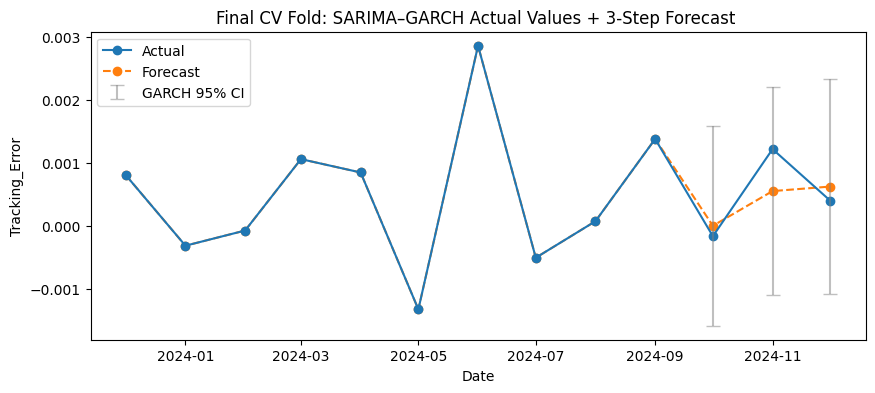


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000462,0.000000,0.690292
1,2.000000,0.001213,0.000002,0.059201
2,3.000000,0.000686,0.000001,0.152582
3,4.000000,0.001480,0.000003,-0.061400
4,5.000000,0.002026,0.000006,-0.196206
5,6.000000,0.000225,0.000000,0.583514


Average Metrics Across Folds:

MAE mean ± std : 0.001015 ± 0.000621
MSE mean ± std : 0.000002 ± 0.000002
R2  mean ± std : 0.204664 ± 0.325249

=== Final Model ===
Order (p,d,q)(P,D,Q)[m] : (2, 1, 1, 1, 0, 1, 12)  AIC=-2569.43  BIC=-2545.18

SARIMA coefficients:


,coef,pvalue
0,-0.000001,0.919295
1,-0.644698,0.000000
2,-0.300463,0.000000
3,-0.881273,0.000000
4,0.084776,0.953623
5,-0.025268,0.986264
6,0.000001,0.000000



GARCH coefficients:


,coef,pvalue
mu,0.026188,0.617908
omega,0.156209,0.009303
alpha[1],0.212664,0.017914
beta[1],0.624556,0.000000
nu,22.991723,0.400052



SARIMA residual diagnostics:


,stat,pvalue,Result
Ljung-Box,31.330956,0.000517,Fail
Jarque-Bera,3.205909,0.201301,Pass
ARCH LM,29.183059,0.001164,Fail
CUSUM,1.026074,0.243092,Pass



GARCH residual diagnostics:


,stat,pvalue,Result
Ljung-Box,21.435508,0.018253,Fail
Jarque-Bera,0.660828,0.718626,Pass
ARCH LM,10.711723,0.380414,Pass
CUSUM,0.795527,0.551437,Pass



=== In-Sample vs Out-of-Sample ===


,R2,MAE,MSE
in_sample,0.264955,0.000900,0.000002
out_sample,0.459988,0.000352,0.000000


In [14]:
sar_res = fit_sarima_garch(
    qqq["Tracking_Error"],
    horizon=3, cv_window=60, cv_step=30,
    forecast_plot=True
)

# ── Cross-validation table ─────────────────────────────────────────────
cv_df = pd.DataFrame({
    "Fold": range(1, sar_res["cv_metrics"]["folds"] + 1),
    "MAE":  sar_res["cv_metrics"]["MAE"]["values"],
    "MSE":  sar_res["cv_metrics"]["MSE"]["values"],
    "R2":   sar_res["cv_metrics"]["R2"]["values"],
})

print("\n=== Cross-Validation Results ===")
display(cv_df.style.format("{:.6f}"))

print("Average Metrics Across Folds:")
print(f"\nMAE mean ± std : {sar_res['cv_metrics']['MAE']['mean']:.6f} ± {sar_res['cv_metrics']['MAE']['std']:.6f}")
print(f"MSE mean ± std : {sar_res['cv_metrics']['MSE']['mean']:.6f} ± {sar_res['cv_metrics']['MSE']['std']:.6f}")
print(f"R2  mean ± std : {sar_res['cv_metrics']['R2']['mean']:.6f} ± {sar_res['cv_metrics']['R2']['std']:.6f}")

# ── Final model summary ───────────────────────────────────────────────
print("\n=== Final Model ===")
print(f"Order (p,d,q)(P,D,Q)[m] : {sar_res['order']}  "
      f"AIC={sar_res['aic']:.2f}  BIC={sar_res['bic']:.2f}")

print("\nSARIMA coefficients:")
display(sar_res["sarima_coef"].round(6))

print("\nGARCH coefficients:")
display(sar_res["garch_coef"].round(6))

def pretty_diag(di):
    df = pd.DataFrame(di).T
    return df[["stat","pvalue","Result"]].round(6)

print("\nSARIMA residual diagnostics:")
display(pretty_diag(sar_res["diagnostics"]["sarima"]))

print("\nGARCH residual diagnostics:")
display(pretty_diag(sar_res["diagnostics"]["garch"]))

print("\n=== In-Sample vs Out-of-Sample ===")
metric_table = pd.DataFrame(sar_res["metrics"]).T
display(metric_table.round(6))


# MS-SARIMA (VIX Switch) Model Fitting

### VIX Visualisation & Regime Fit

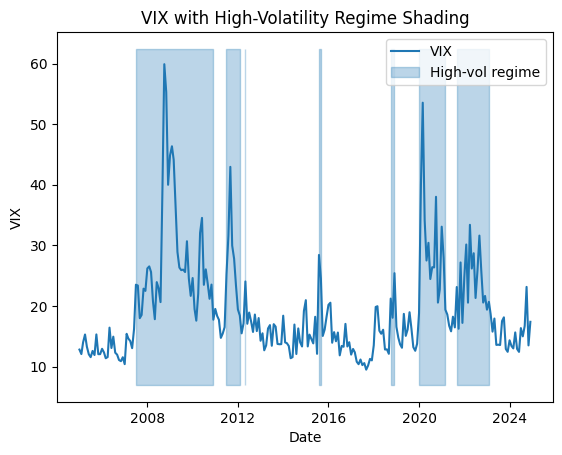

In [42]:
vix = macro['vix']

# 1) Fit 2-state Markov model on VIX
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# 2) Extract high-volatility regime probability
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]

# 3) Plot VIX and highlight high-vol regions
fig, ax = plt.subplots()
x = vix.index

# Plot VIX line
line, = ax.plot(x, vix.values, label='VIX')

# Determine vertical extent
ymin, ymax = ax.get_ylim()

# Shade high-volatility regimes (probability > 0.5)
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.35),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Labels, title, legend
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')
ax.legend(loc='upper right')

plt.show()


### VIX Series Standardisation

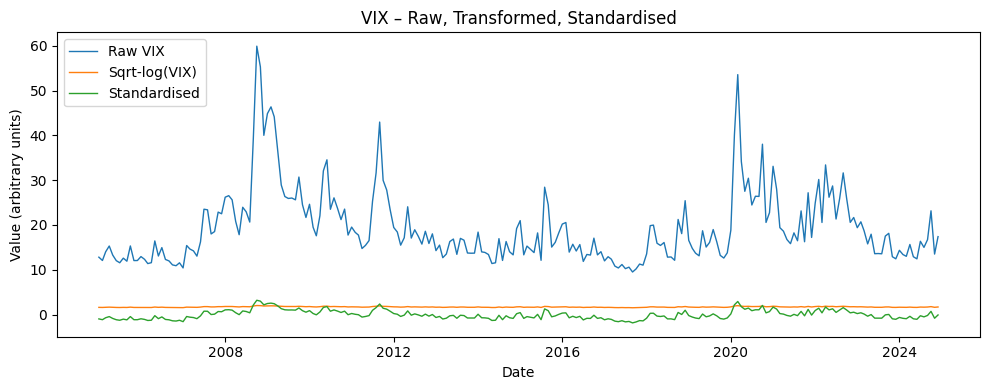

In [43]:
# VIX Series Standardisation
vix_pre = (np.sqrt(np.log1p(vix)))               # variance‑stabilise
vix_std = (vix_pre - vix_pre.mean()) / vix_pre.std() # z‑score

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(vix.index, vix, label="Raw VIX", lw=1)
ax.plot(vix_pre.index, vix_pre, label="Sqrt‑log(VIX)", lw=1)
ax.plot(vix_std.index, vix_std, label="Standardised", lw=1)
ax.set_title("VIX – Raw, Transformed, Standardised")
ax.set_xlabel("Date"); ax.set_ylabel("Value (arbitrary units)")
ax.legend(loc="upper left")
plt.tight_layout()

### MS SARIMA Model

In [44]:
def fit_ms_sarima_vix(
    series: pd.Series,
    vix: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 10,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    regime_thresh: float = 0.5,
    ljungbox_lags: int = 10,
    alpha: float = 0.05,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5, max_dD: int = 3,
    forecast_plot: bool = True,
):
    """
    Two-state VIX-driven MS-SARIMA with expanding-window CV and
    regime-weighted GARCH 95 % CIs on the final forecast.

    Return keys include:
      transition_matrix
      orders            {'low','high'}
      sarima_coefs      {'low','high'}
      garch_coefs       {'low','high'}   # NEW
      diagnostics       {'low','high'}
      ic                {'low','high'}   # AIC / BIC
      cv_metrics
      metrics
    """

    # ── data prep ───────────────────────────────────────────────────────────
    y = series.dropna()
    v = vix.reindex_like(y).fillna(method="ffill")
    if len(y) < cv_window + horizon:
        raise ValueError("series too short for chosen cv_window + horizon")

    # --- tiny helpers -------------------------------------------------------
    def regime_fit(ts: pd.Series):
        ts_t, tf_par = winsorize_yj(ts, winsor_limits)
        mod = auto_arima(
            ts_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )
        fc = inv_yj(mod.predict(horizon), tf_par)
        return mod, tf_par, fc

    def regimes(v_sub: pd.Series):
        res = MarkovRegression(
            v_sub, k_regimes=2, trend="c", switching_variance=True
        ).fit(disp=False)
        p00, p10 = res.params["p[0->0]"], res.params["p[1->0]"]
        P = np.array([[p00, 1 - p00],
                      [p10, 1 - p10]])
        return res.smoothed_marginal_probabilities.iloc[:, 1], P  # prob_high

    # ── 1. EXPANDING-WINDOW CV (unchanged logic) ────────────────────────────
    mae, mse, r2 = [], [], []
    for end in range(cv_window, len(y) - horizon + 1, cv_step):
        y_tr, y_te = y.iloc[:end], y.iloc[end:end + horizon]
        prob, P = regimes(v.iloc[:end])
        flag = prob > regime_thresh

        if flag.all() or (~flag).all():          # single-regime window
            lo_mod, lo_tf, lo_fc = regime_fit(y_tr)
            hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
        else:
            lo_mod, lo_tf, lo_fc = regime_fit(y_tr.loc[~flag])
            hi_mod, hi_tf, hi_fc = regime_fit(y_tr.loc[ flag])

        p_vec = np.array([1 - prob.iloc[-1], prob.iloc[-1]])
        fc_mix = []
        for h in range(horizon):
            p_vec = p_vec @ P
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])

        mae.append(mean_absolute_error(y_te, fc_mix))
        mse.append(mean_squared_error(y_te, fc_mix))
        r2.append(r2_score(y_te, fc_mix))

    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ── 2. FINAL FIT ---------------------------------------------------------
    tr_y, te_y = y.iloc[:-horizon], y.iloc[-horizon:]
    prob_f, P_f = regimes(v.iloc[:-horizon])
    flag_f = prob_f > regime_thresh

    if flag_f.all() or (~flag_f).all():
        lo_mod, lo_tf, lo_fc = regime_fit(tr_y)
        hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
    else:
        lo_mod, lo_tf, lo_fc = regime_fit(tr_y.loc[~flag_f])
        hi_mod, hi_tf, hi_fc = regime_fit(tr_y.loc[ flag_f])

    # --- coefficient & IC tables -------------------------------------------
    lo_coef = pd.DataFrame({
        "coef": lo_mod.arima_res_.params,
        "pvalue": lo_mod.arima_res_.pvalues})
    hi_coef = pd.DataFrame({
        "coef": hi_mod.arima_res_.params,
        "pvalue": hi_mod.arima_res_.pvalues})

    ic = {
        "low":  {"aic": float(lo_mod.arima_res_.aic),
                 "bic": float(lo_mod.arima_res_.bic)},
        "high": {"aic": float(hi_mod.arima_res_.aic),
                 "bic": float(hi_mod.arima_res_.bic)},
    }

    # --- GARCH on each regime ----------------------------------------------
    def garch_sigma(mod, tf_par, sub_series):
        resid = pd.Series(mod.arima_res_.resid,
                          index=sub_series.index[-len(mod.arima_res_.resid):])
        z = resid / resid.std()
        gfit = arch_model(z, vol="Garch", p=1, q=1,
                          dist="t", rescale=False).fit(disp="off")
        var_h = gfit.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
        sigma = np.sqrt(var_h) * resid.std()
        return gfit, sigma

    g_lo, sig_lo = garch_sigma(lo_mod, lo_tf, tr_y.loc[~flag_f] if (~flag_f).any() else tr_y)
    g_hi, sig_hi = garch_sigma(hi_mod, hi_tf, tr_y.loc[ flag_f] if flag_f.any()   else tr_y)

    garch_coefs = {
        "low":  pd.DataFrame({"coef": g_lo.params, "pvalue": g_lo.pvalues}),
        "high": pd.DataFrame({"coef": g_hi.params, "pvalue": g_hi.pvalues}),
    }

    # --- in-sample fitted & horizon forecast -------------------------------
    lo_fit = inv_yj(lo_mod.predict_in_sample(), lo_tf)
    hi_fit = inv_yj(hi_mod.predict_in_sample(), hi_tf)
    fitted = pd.Series(index=tr_y.index, dtype=float)
    fitted.loc[~flag_f] = lo_fit
    fitted.loc[ flag_f] = hi_fit

    p_vec = np.array([1 - prob_f.iloc[-1], prob_f.iloc[-1]])
    fc_mix, sigma_mix, hi_prob_pred = [], [], []
    for h in range(horizon):
        p_vec = p_vec @ P_f
        hi_prob_pred.append(p_vec[1])
        # point forecast
        fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])
        # variance mix  (weighted by probabilities)
        sigma_mix.append(np.sqrt(p_vec[0] * sig_lo[h]**2 +
                                 p_vec[1] * sig_hi[h]**2))

    # --- diagnostics & metrics ---------------------------------------------
    diag_low  = run_diagnostics(
        pd.Series(lo_mod.arima_res_.resid,
                  index=tr_y.loc[~flag_f].index if (~flag_f).any() else tr_y.index),
        lags=ljungbox_lags, alpha=alpha)
    diag_high = run_diagnostics(
        pd.Series(hi_mod.arima_res_.resid,
                  index=tr_y.loc[ flag_f].index if flag_f.any() else tr_y.index),
        lags=ljungbox_lags, alpha=alpha)

    metrics = {
        "in_sample": {
            "R2":  r2_score(tr_y, fitted),
            "MAE": mean_absolute_error(tr_y, fitted),
            "MSE": mean_squared_error(tr_y, fitted),
        },
        "out_sample": {
            "R2":  r2_score(te_y, fc_mix),
            "MAE": mean_absolute_error(te_y, fc_mix),
            "MSE": mean_squared_error(te_y, fc_mix),
        },
    }

    # ── 3. PLOT with GARCH CIs ---------------------------------------------
    if forecast_plot:
        prev_n = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev], te_y.values],
                 "-o", color="C0", label="Actual", zorder=2)
        plt.plot(np.r_[idx_prev, te_y.index],
                 np.r_[y.loc[idx_prev].values, fc_mix],
                 "--o", color="C1", label="Forecast", zorder=1)
        # 95 % CI
        plt.errorbar(te_y.index, fc_mix, yerr=1.96 * np.array(sigma_mix),
                     fmt="none", ecolor="grey", alpha=0.5, capsize=5,
                     label="GARCH 95% CI")

        shade = pd.concat([
            prob_f.iloc[-prev_n:], pd.Series(hi_prob_pred, index=te_y.index)
        ])
        ymin, ymax = plt.ylim()
        plt.fill_between(shade.index, ymin, ymax,
                         where=shade > regime_thresh,
                         color="C2", alpha=0.3, label="High-Vol Regime")
        plt.title("Final model: MS-SARIMA + GARCH CIs")
        plt.xlabel("Date"); plt.ylabel(series.name or "Value")
        plt.legend(loc="upper left"); plt.show()

    # ── RETURN raw values ---------------------------------------------------
    return {
        "transition_matrix": P_f,
        "orders": {
            "low":  lo_mod.order + lo_mod.seasonal_order,
            "high": hi_mod.order + hi_mod.seasonal_order,
        },
        "ic": ic,
        "sarima_coefs": {"low": lo_coef, "high": hi_coef},
        "garch_coefs":  garch_coefs,                   # NEW
        "diagnostics":  {"low": diag_low, "high": diag_high},
        "cv_metrics":   cv_metrics,
        "metrics":      metrics,
        "sigma_forecast": sigma_mix,                   # horizon σ mix (optional)
    }


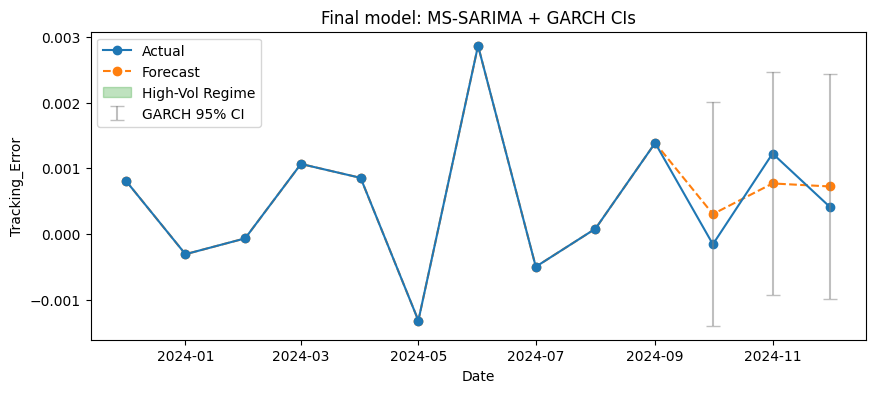


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000461,0.000000,0.685336
1,2.000000,0.001208,0.000002,0.075862
2,3.000000,0.000629,0.000000,0.264311
3,4.000000,0.001595,0.000003,-0.098989
4,5.000000,0.001847,0.000005,0.039159
5,6.000000,0.000174,0.000000,0.770925


MAE mean ± std : 0.000985 ± 0.000609
MSE mean ± std : 0.000002 ± 0.000002
R2 mean ± std : 0.289434 ± 0.328716

=== Final Model ===

Transition matrix:
        to low  to high
low→    0.967    0.033
high→   0.051    0.949

Low-vol  Order (p,d,q)(P,D,Q)[m] : (2, 0, 0)((0, 0, 1))[12]  AIC=-1462.99  BIC=-1448.50


,coef,pvalue
0,0.004411,0.000000
1,-0.499092,0.000000
2,-0.227015,0.018035
3,0.246048,0.017228
4,0.000001,0.000000



High-vol Order (p,d,q)(P,D,Q)[m] : (0, 0, 2)((0, 0, 0))[12]  AIC=-1057.15  BIC=-1046.61


,coef,pvalue
0,0.004830,0.000000
1,-0.500858,0.000001
2,-0.139225,0.066568
3,0.000002,0.000000



Low-vol GARCH coefficients


,coef,pvalue
mu,0.041113,0.625569
omega,0.026355,0.301867
alpha[1],0.000000,1.000000
beta[1],0.965392,0.000000
nu,220.252030,0.328717



High-vol GARCH coefficients


,coef,pvalue
mu,0.090520,0.166747
omega,0.065958,0.152355
alpha[1],0.369505,0.101978
beta[1],0.630391,0.000002
nu,4.738084,0.024945



Diagnostics (low-vol):


,stat,pvalue,Result
Ljung-Box,31.959564,0.000407,Fail
Jarque-Bera,2.10013,0.349915,Pass
ARCH LM,6.660077,0.757099,Pass
CUSUM,1.631208,0.009769,Fail



Diagnostics (high-vol):


,stat,pvalue,Result
Ljung-Box,26.901034,0.0027,Fail
Jarque-Bera,9.164207,0.010233,Fail
ARCH LM,19.785307,0.03135,Fail
CUSUM,1.213969,0.104932,Pass



In / Out sample metrics


,R2,MAE,MSE
in_sample,0.274787,0.000898,0.000002
out_sample,0.461657,0.000411,0.000000


In [46]:
ms_res = fit_ms_sarima_vix(
    series = qqq["Tracking_Error"],
    vix    = vix_std,
    horizon=3, cv_window=60, cv_step=30,
    regime_thresh=0.5,
    forecast_plot=True
)

# Cross-validation
print("\n=== Cross-Validation Results ===")
cv_df = pd.DataFrame({
    "Fold": range(1, ms_res["cv_metrics"]["folds"] + 1),
    "MAE":  ms_res["cv_metrics"]["MAE"]["values"],
    "MSE":  ms_res["cv_metrics"]["MSE"]["values"],
    "R2":   ms_res["cv_metrics"]["R2"]["values"],
})
display(cv_df.style.format("{:.6f}"))
for k in ["MAE","MSE","R2"]:
    print(f"{k} mean ± std : {ms_res['cv_metrics'][k]['mean']:.6f} ± "
          f"{ms_res['cv_metrics'][k]['std']:.6f}")

# Final-model summary
print("\n=== Final Model ===")
print("\nTransition matrix:\n", pd.DataFrame(
        ms_res["transition_matrix"],
        index=["low→","high→"], columns=["to low","to high"]
).round(3))

low_order  = ms_res["orders"]["low"]   # (p,d,q,P,D,Q,m)
print("\nLow-vol  Order (p,d,q)(P,D,Q)[m] : "
      f"{low_order[:3]}({low_order[3:6]})[{low_order[6]}]  "
      f"AIC={ms_res['ic']['low']['aic']:.2f}  "
      f"BIC={ms_res['ic']['low']['bic']:.2f}")
display(ms_res["sarima_coefs"]["low"].round(6))

high_order = ms_res["orders"]["high"]
print("\nHigh-vol Order (p,d,q)(P,D,Q)[m] : "
      f"{high_order[:3]}({high_order[3:6]})[{high_order[6]}]  "
      f"AIC={ms_res['ic']['high']['aic']:.2f}  "
      f"BIC={ms_res['ic']['high']['bic']:.2f}")
display(ms_res["sarima_coefs"]["high"].round(6))

print("\nLow-vol GARCH coefficients");  display(ms_res["garch_coefs"]["low"].round(6))
print("\nHigh-vol GARCH coefficients"); display(ms_res["garch_coefs"]["high"].round(6))


def pretty(di):
    df = pd.DataFrame(di).T
    return df[["stat","pvalue","Result"]].round(6)
print("\nDiagnostics (low-vol):")
display(pretty(ms_res["diagnostics"]["low"]))
print("\nDiagnostics (high-vol):")
display(pretty(ms_res["diagnostics"]["high"]))

print("\nIn / Out sample metrics")
display(pd.DataFrame(ms_res["metrics"]).T.round(6))
